<a href="https://colab.research.google.com/github/decci027/datascience_a2/blob/main/Unit7Project_DekiT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Context:
In botany, these trends help differentiate species, track adaptations, and support conservation efforts. In data science and machine learning, the dataset serves as a benchmark for classification models, demonstrating how feature importance influences predictions. Additionally, recognizing these patterns aids in agriculture, selective breeding, and ecological research, making the dataset a valuable tool across multiple fields.

In [17]:
!pip install git+https://github.com/pydata/xarray.git
!pip install bambi

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import xarray as xr
import bambi as bmb
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-ujj8xi3z
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-ujj8xi3z
  Resolved https://github.com/pydata/xarray.git to commit 0184702f16c3f744fc9096c7dac690626dcc6922
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
iris = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/iris.csv')

In [4]:
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [5]:
model_iris = bmb.Model("sepal_length ~ sepal_width", iris)
idata = model_iris.fit()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


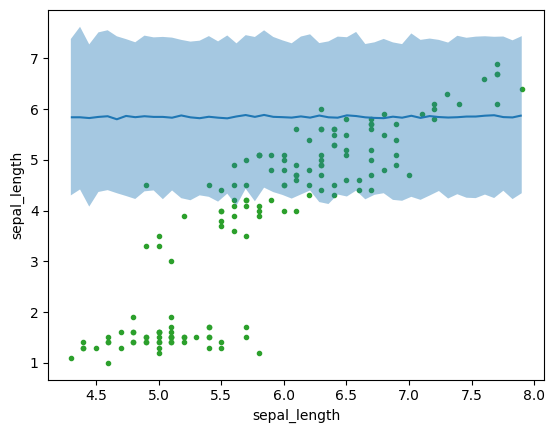

In [6]:
bmb.interpret.plot_predictions(model_iris, idata, "sepal_length", pps=True)
plt.plot(iris.sepal_length, iris.petal_length,"C2.", zorder=-3)

This graph represents the relationship between sepal length and petal length in the iris dataset, with a Bayesian model's predictions overlaid in blue. The solid blue line represents the model’s estimated trend while the shaded region reflects the uncertainty in the predictions. Most of the green data points fall within this credible interval but as shown, some points lie outside of the shaded area. These outliers indicate that the model doesn’t perfectly capture all variations in the data—possibly due to other influencing factors like species differences. The presence of these points outside the shaded region is significant because it highlights the limitations of our model; while it captures the general trend, it doesn't account for all nuances. Despite this, the graph is still useful in predicting our posterior distribution, as it gives us a probable range of expected petal lengths given a sepal length. The width of the blue shaded area also provides insight into the model’s confidence—narrower regions suggest more certainty, while wider areas indicate higher uncertainty, which helps us interpret the reliability of our predictions.

In [7]:
#convert from pandas to numpy array
petal_length = iris["petal_length"].values
sepal_length = iris["sepal_length"].values[:,None]

In [8]:
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [9]:
import pymc as pm

In [10]:
!pip install preliz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.1/517.1 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 17.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [11]:
import preliz as pz

In [12]:
with pm.Model() as model_hsgp:
    #prior for our smoothness parameter
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(sepal_length))

    #this is our kernal, which decides how our points relate to one another
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    #this specfices that we're using an HSGP
    gp = pm.gp.HSGP(m=[10], c=1.5, cov_func=cov)

    #f is for function, as in the function we use to transform our data
    f = gp.prior('f', X=sepal_length)
    #prior for the neg binomial
    α = pm.HalfNormal('α', 1)
    #likelihood
    y = pm.NegativeBinomial("y", np.exp(f), α, observed=petal_length)

    idata_hsgp = pm.sample()

Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


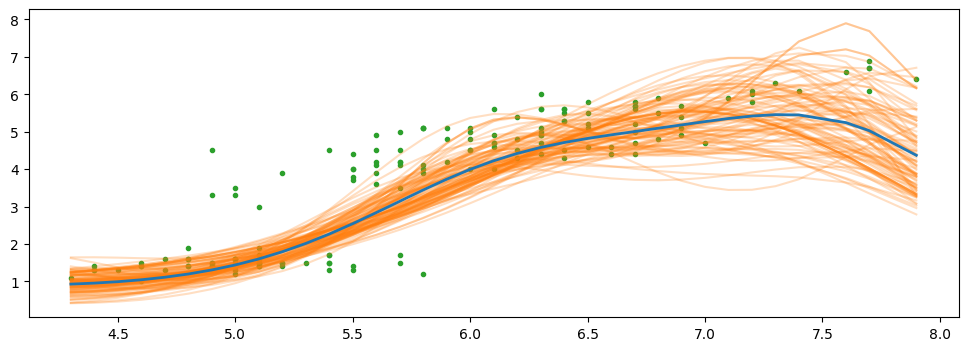

In [13]:
#set up plot
_, ax = plt.subplots(1, 1, figsize=(12, 4))
#plot raw data
ax.plot(iris["sepal_length"].values, iris["petal_length"].values, "C2.")

#grab posterior
f = az.extract(idata_hsgp, group="posterior", var_names="f")


idx = np.argsort(iris["sepal_length"].values)
#plot samples of the posterior
ax.plot(iris["sepal_length"].values[idx], np.exp(f.values[idx,:100]), alpha=0.25, color="C1")
#plot posterior mean
ax.plot(iris["sepal_length"].values[idx], np.exp(f.values[idx].mean(1)), color="C0", lw=2)

This graph shows the relationship between sepal length and petal length. The green dots represent the raw data, while the orange lines depict posterior samples, illustrating the model’s uncertainty—notice how they spread out more where data is sparse (around 4.5 and 7.5 sepal length). The blue line, representing the posterior mean, captures the overall trend but smooths out individual variations. This is important because it allows for a flexible, non-linear fit while quantifying uncertainty, helping make more informed predictions. However, I think that this model could be improved by increasing the number of knots in the spline to capture finer patterns, adjusting priors to better balance flexibility and regularization, or reconsidering the likelihood function since negative binomial may not be the best fit for petal length data. The final spline model introduces more flexibility by using a degree-12 spline, but there’s a risk of overfitting, meaning it might follow noise instead of the true trend. Compared to HSGP, it lacks uncertainty quantification, making it harder to assess confidence in predictions. Fine-tuning the number of knots and testing different priors could help achieve a more balanced and interpretable model.

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


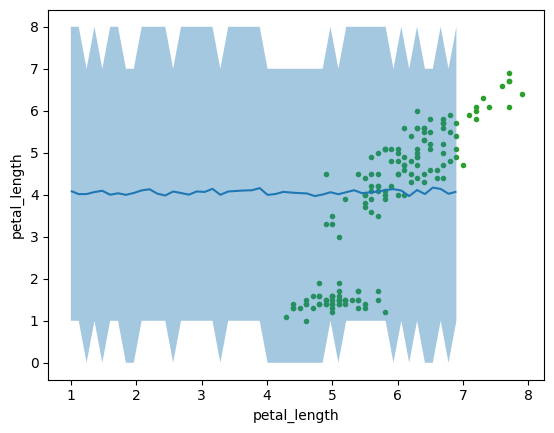

In [14]:
num_knots = 6
knots = np.linspace(iris["sepal_length"].min(), iris["sepal_length"].max(), num_knots + 2)[1:-1]
model_spline = bmb.Model("petal_length ~ bs(sepal_length, degree=12, knots=knots)", iris, family="negativebinomial")  # Increased degree
# Fit the model_spline and obtain InferenceData
idata_spline = model_spline.fit() #This line is added to fit the model and obtain the correct idata_spline
bmb.interpret.plot_predictions(model_spline, idata_spline, "petal_length", pps=True)
plt.plot(iris.sepal_length, iris.petal_length, "C2.", zorder=-3)

In [15]:
num_knots = 10
knots = np.linspace(iris["sepal_length"].min(), iris["sepal_length"].max(), num_knots + 2)[1:-1]
model_spline = bmb.Model("petal_length ~ bs(sepal_length, degree=3, knots=knots)", iris, family="negativebinomial")
idata_spline = model_spline.fit()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


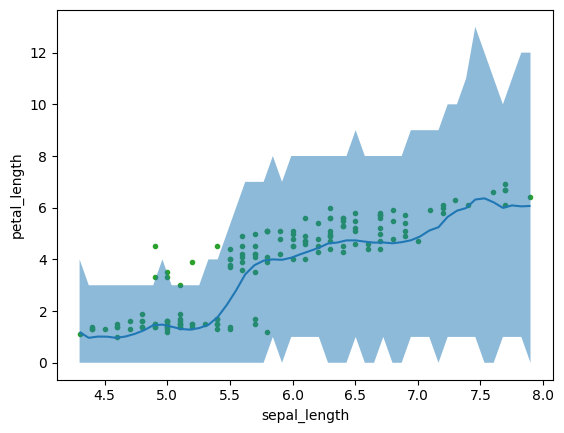

In [16]:
bmb.interpret.plot_predictions(model_spline, idata_spline, "sepal_length", pps=True)
plt.plot(iris.sepal_length, iris.petal_length, "C2.", zorder=-3)
# Get the current axis
ax = plt.gca()

# Find the polygon representing the credible interval
for collection in ax.collections:
    if isinstance(collection, plt.matplotlib.collections.PolyCollection):
        collection.set_alpha(0.5)  # Adjust the alpha value as desired

plt.show()

The final graph shows how sepal length and petal length relate in the Iris dataset using a Bayesian spline regression. The blue line represents the model’s predicted trend, while the shaded region shows uncertainty—the wider the area, the less confident the model is. The curve isn’t perfectly linear because petal length grows faster at certain sepal lengths (around 5.5 to 6.5 cm), and the model reflects that. The biggest reason the posterior looks like this is data density; predictions are more reliable where there are more points (~6 to 7 cm) and get shakier at the extremes due to fewer samples. This matters because it highlights how sepal length is a solid predictor but not the whole story—species type and other factors probably play a role too. To improve this, I could have added species as a predictor, gather more data for better certainty at the edges, tweak the spline flexibility, or run model diagnostics to see if another method works better.


###Conclusion:
The Iris dataset remains a fundamental resource in data science and machine learning due to its simplicity, well-balanced class distribution, and real-world applicability in classification problems. Through probabilistic  Bayesian inference, we can compare prior assumptions with posterior distributions, gaining a more refined understanding of class separability.
Initially, the prior distribution assumes equal probabilities for all Iris species without considering specific feature relationships. However, the posterior distribution—updated using actual data—reveals the true underlying structure, reducing uncertainty and improving classification accuracy. The posterior graph better reflects the likelihood of each species based on observed features like petal length and sepal width, enhancing predictive reliability.